# Load Packages

In [44]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
import tensorflow as tf

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import os
import cv2
import numpy as np
import pandas as pd
from random import randint

from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Load Data

In [17]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for NORMAL , 1 for TypeA, 2 for TypeB, 3 for TypeC
    label = 0
    folders=['NORMAL','Type A','Type B','Type C']
    
    for labels in folders: #Main Directory where each class label is present as folder name.
        if labels == 'NORMAL': #Folder contain  NORMAL get the '0' class label.
            label = 0
        elif labels == 'Type A':
            label = 1
        elif labels == 'Type B':
            label = 2
        elif labels == 'Type C':
            label = 3
 
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image 
            image = cv2.resize(image,(224,224)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            image = image/255.0 #normalize value to get floats ranging from 0 to 1 
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=123) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {0:'Normal', 1:'A', 2:'B', 3:'C'}  
    return labels[class_code]         


In [8]:
Images, Labels = get_images('/Users/jiahuili/Desktop/Spring 2020/MSA 8150 ML/MSA8150 Projects 2020/BP-Lung Xray/Data/') #Extract the training images from the folders.
Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [9]:
print("batch_size, height, width, channels:",Images.shape)

batch_size, height, width, channels: (2389, 224, 224, 3)


# Visualization

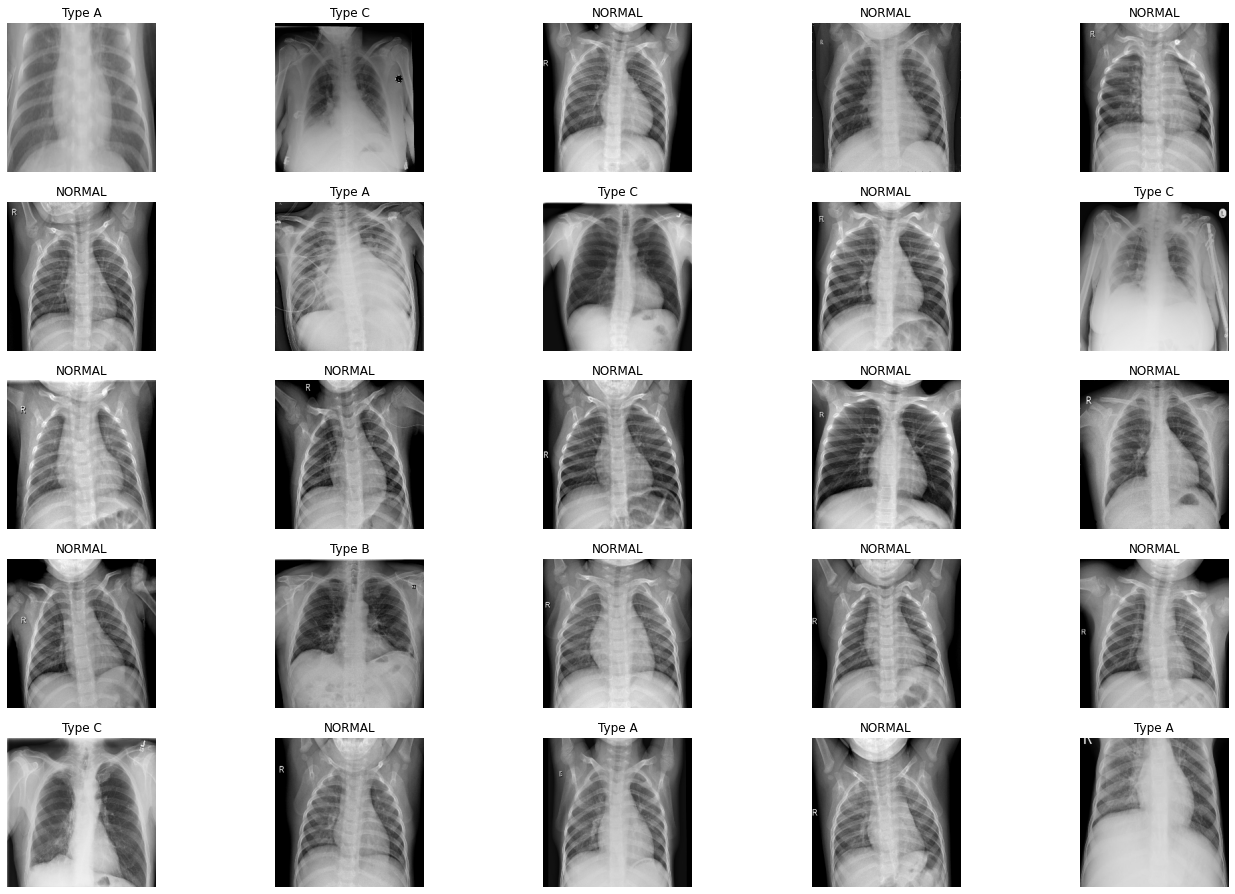

In [5]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

# Split dataset into training and validation

In [265]:
X_train,X_valid, y_train, y_valid = train_test_split(Images,Labels,train_size=0.7, random_state=42)

In [266]:
X_train.shape

(1672, 224, 224, 3)

In [267]:
X_valid.shape

(717, 224, 224, 3)

# Modeling

### a) train base model

In [276]:
#original one
def train_base_model():
    model = Models.Sequential()
    
    model.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
    model.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
    model.add(Layers.MaxPool2D(5,5))

    model.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
    model.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
    model.add(Layers.MaxPool2D(5,5))

    model.add(Layers.Flatten())
    model.add(Layers.Dense(50,activation='relu'))
    model.add(Layers.Dense(6,activation='softmax'))

    model.compile(optimizer=Optimizer.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    
    return model

In [278]:
model=train_base_model()

# fit model
model1 = model.fit(X_train, y_train, epochs=20, validation_data =(X_valid, y_valid))

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_232 (Conv2D)          (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 44, 44, 16)        0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 42, 42, 32)        4640      
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 2048)            

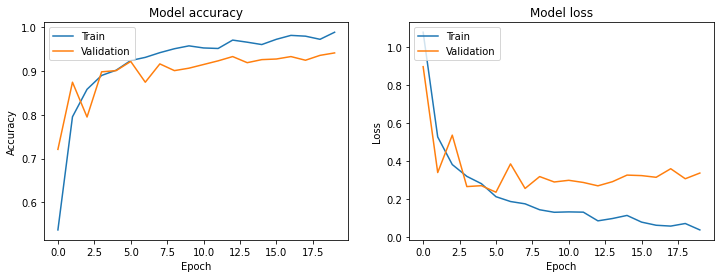

In [280]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.subplot(1,2,1)
plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### b) train model for improvement
- add dropout layer to avoid overfitting

In [305]:
#improvement
def train_model2():
    model = Models.Sequential()
    
    model.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
    model.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
    model.add(Layers.MaxPool2D(5,5))

    model.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
    model.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
    model.add(Layers.MaxPool2D(5,5))

    model.add(Layers.Flatten())
    model.add(Layers.Dense(50,activation='relu'))
    model.add(Layers.Dropout(rate=0.5))
    model.add(Layers.Dense(6,activation='softmax'))

    model.compile(optimizer=Optimizer.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    
    return model

In [306]:
model=train_model2()

# fit model
model2 = model.fit(X_train, y_train, epochs=20, validation_data =(X_valid, y_valid))

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_244 (Conv2D)          (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_245 (Conv2D)          (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 44, 44, 16)        0         
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 42, 42, 32)        4640      
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_124 (MaxPoolin (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 2048)            

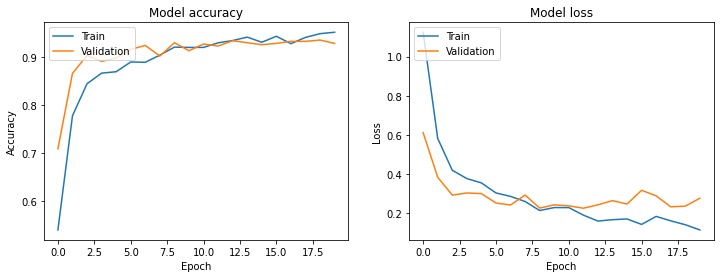

In [307]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.subplot(1,2,1)
plt.plot(model2.history['accuracy'])
plt.plot(model2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### c) Early stop to save the best model
- save the best model by the highest validation accuracy
- stop training if no improvement on validation loss for 10 epochs
- use learning rate schedules to lower the learing rate if no improvement on validation loss for 4 epochs

In [309]:
model=train_model2()

# early stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4)

# fit model
model3 = model.fit(X_train, y_train, epochs=300, validation_data =(X_valid, y_valid),callbacks=[es, mc, lr_scheduler])


Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_252 (Conv2D)          (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 44, 44, 16)        0         
_________________________________________________________________
conv2d_254 (Conv2D)          (None, 42, 42, 32)        4640      
_________________________________________________________________
conv2d_255 (Conv2D)          (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_55 (Flatten)         (None, 2048)            

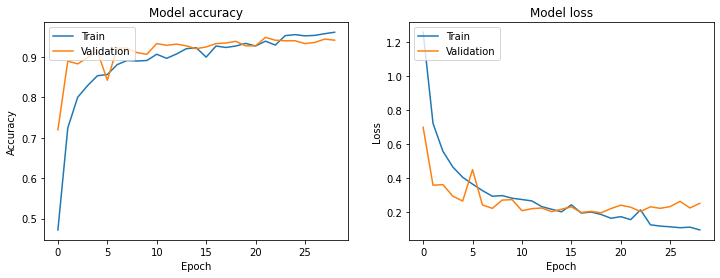

In [310]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.subplot(1,2,1)
plt.plot(model3.history['accuracy'])
plt.plot(model3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model3.history['loss'])
plt.plot(model3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Load the saved model

In [117]:
saved_model = tf.keras.models.load_model('best_model.h5')

# Model Evaluation on train and validation

In [328]:
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, validation_acc = saved_model.evaluate(X_valid, y_valid, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, validation_acc))

Train: 0.972, Validation: 0.948


# Model Evaluation on the whole dataset

In [13]:
train_loss, train_acc = saved_model.evaluate(Images, Labels, verbose=0)

In [15]:
print('Train Accuracy: %.3f' % (train_acc))
print('Train Loss: %.3f' % (train_loss))

Train Accuracy: 0.965
Train Loss: 0.115


# Prediction 

In [118]:
def text_images(directory):
    Images = []
    NameOfTestSample =[]
    
    for image_file in os.listdir(directory): # loop to load test images
        image = cv2.imread(directory+image_file) #Reading the image 
        image = cv2.resize(image,(224,224)) #Resize the image, Some images are different sizes. (Resizing is very Important)
        image = image/255.0 #normalize value to get floats ranging from 0 to 1 
        Images.append(image)
        NameOfTestSample.append(image_file.split('.')[0]) # save the image name
    
    return (Images,NameOfTestSample)

In [119]:
# load test data
pred_images,NameOfTestSample = text_images('/Users/jiahuili/Desktop/Spring 2020/MSA 8150 ML/MSA8150 Projects 2020/BP-Lung Xray/Data/Test Images/')
pred_images = np.array(pred_images)


In [120]:
# check the shape
pred_images.shape

(266, 224, 224, 3)

In [121]:
# prediction
pred=saved_model.predict_classes(pred_images)
#print(pred)

# convert integers back to label name
pred_type=[get_classlabel(i) for i in pred]
#print(pred_type)

In [122]:
# save it as dataframe
df = pd.DataFrame(list(zip(NameOfTestSample, pred_type)), 
               columns =['NameOfTestSample', 'Type']) 

In [123]:
df.head()

,NameOfTestSample,Type
0,Test_Sample23,Normal
1,Test_Sample37,A
2,Test_Sample158,A
3,Test_Sample170,Normal
4,Test_Sample164,Normal


In [124]:
import re 
temp_list = []

for name in NameOfTestSample:
    temp = name.split('Sample')[1]
    temp = int(temp)
    temp_list.append(temp)

In [125]:
df['temp_list']=temp_list

In [126]:
df.head()

,NameOfTestSample,Type,temp_list
0,Test_Sample23,Normal,23
1,Test_Sample37,A,37
2,Test_Sample158,A,158
3,Test_Sample170,Normal,170
4,Test_Sample164,Normal,164


In [127]:
df_TestResults=df.sort_values(by=['temp_list']).reset_index(drop=True)

In [146]:
df_TestResults

,NameOfTestSample,Type,temp_list
0,Test_Sample1,Normal,1
1,Test_Sample2,C,2
2,Test_Sample3,Normal,3
3,Test_Sample4,A,4
4,Test_Sample5,A,5
...,...,...,...
261,Test_Sample262,C,262
262,Test_Sample263,B,263
263,Test_Sample264,A,264
264,Test_Sample265,Normal,265


In [144]:
# export the data
df_TestResults[['Type']].to_csv("L.csv",index = False)

In [145]:
#check the save csv file
pd.read_csv('L.csv')

,Type
0,Normal
1,C
2,Normal
3,A
4,A
...,...
261,C
262,B
263,A
264,Normal
